# HW2 - Amit Parizat & Yoel Melul

## Theory Questions

### Q1
**To evaluate how well our model performs at T1D classification, we need to have evaluation metrics that measures of its performances/accuracy. Which evaluation metric is more important to us: model accuracy or model performance? Give a simple example that illustrates your claim.**

In our model, the more important evaluation metric is model performance. Like we saw in lecture "*C08 - Practical consideration on training a model II*" in slide 8, accuracy could be high even when the classifier misclassifies most of 'Yes' labeled examples. For example, when 99% percent of the data is labeled 'No' and only 1% is labeled 'Yes' (could be our case since most of the population doesn't have diabetes), even when the classifier labeles 'No' all the examples we obtain high accuracy. In this case, performance statistics such as sensitivity, PPV and F1 would be more informative.

### Q2
**T1D is often associated with other comorbidities such as a heart attack. You are asked to design a ML algorithm to predict which patients are going to suffer a heart attack. Relevant patient features for the algorithm may include blood pressure (BP), body-mass index (BMI), age (A), level of physical activity (P), and income (I). You should choose between two classifiers: the first uses only BP and BMI features and the other one uses all of the features available to you. Explain the pros and cons of each choice.**

When using only two features we create a simpler model that requires less computational effort to be made and less memory space to accommodate weights or any other information about the model. However, when not taking into consideration all of the data provided, we may miss important information that may have high indicativity on heart attacks. We may also miss trasformations of the neglected features that could yield valuable new features.

### Q3
**A histologist wants to use machine learning to tell the difference between pancreas biopsies that show signs of T1D and those that do not. She has already come up with dozens of measurements to take, such as color, size, uniformity and cell-count, but she isn’t sure which model to use. The biopsies are really similar, and it is difficult to distinguish them from the human eye, or by just looking at the features. Which of the following is better: logistic regression, linear SVM or nonlinear SVM? Explain your answer.**

The best model of the above for such case is the nonlinear SVM model. Since the current features the histologist has don't have significant correlation with T1D, there might be a nonlinear combination of them that could have a better correlation.

### Q4
**What are the differences between LR and linear SVM and what is the difference in the effect/concept of their hyper-parameters tuning?**

Logistic regression is based on probabilistically separating the data through the sigmoid function, asigning each data point to the class with the highest probability of including it. In contrast, linear SVMs are based on a geometrical separation of the data, finding the hyperplane with the widest margin that will separate data points to several classifications. When tuning hyper-parameters in LR we tune a single parameter $(\lambda)$, while in SVM we tune a set of parameters $(C,\gamma)$, this is why grid search can be computationally expensive.

## Coding Assignment

### Part 1
**Load the data. Explain any preprocessing.**

Import modules

In [52]:
import pandas as pd 
import numpy as np
from pathlib import Path
import random
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use(['ggplot'])

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, hinge_loss, plot_confusion_matrix, confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import KernelPCA

%load_ext autoreload
random.seed(10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load data

In [2]:
file = Path.cwd().joinpath('HW2_data.csv')
dataset = pd.read_csv(file)

Check for nan values

In [3]:
nan_examples = set()
nan_features = set()
for feat in dataset.columns:
    for index in dataset.index:
        if pd.isna(dataset[feat][index]):
            print(feat, index, end=', ')
            nan_examples.add(index)
            nan_features.add(feat)
print('\n\nThere are %.f examples containing nans.' %len(nan_examples))
print('There are %.f features containing nans.' %len(nan_features))

Increased Thirst 521, Increased Thirst 522, Increased Thirst 523, Increased Thirst 524, Increased Thirst 525, Increased Thirst 526, Increased Thirst 527, Increased Thirst 528, Increased Thirst 529, Increased Thirst 544, Increased Thirst 545, Increased Thirst 546, Increased Thirst 547, Increased Thirst 548, Increased Thirst 549, Increased Thirst 550, Increased Thirst 551, Increased Thirst 552, Increased Thirst 553, Increased Thirst 554, Sudden Weight Loss 521, Sudden Weight Loss 525, Sudden Weight Loss 526, Sudden Weight Loss 527, Sudden Weight Loss 528, Sudden Weight Loss 529, Sudden Weight Loss 530, Sudden Weight Loss 531, Sudden Weight Loss 532, Increased Hunger 530, Increased Hunger 531, Increased Hunger 532, Increased Hunger 533, Increased Hunger 534, Increased Hunger 535, Increased Hunger 536, Increased Hunger 537, Increased Hunger 538, Increased Hunger 539, Increased Hunger 540, Increased Hunger 541, Increased Hunger 542, Genital Thrush 548, Genital Thrush 549, Genital Thrush 550

Drop examples containing  nans

In [4]:
c_dataset = dataset.drop(nan_examples, axis=0)

Change 'Yes' to '1' and 'No' to '0'

In [5]:
c_dataset = c_dataset.rename(columns={'Gender': 'Male'})
c_dataset = c_dataset.replace(to_replace=['No', 'Negative', 'Female', 'Yes', 'Positive', 'Male'], value=[0, 0, 0, 1, 1, 1])

Check the dataset is cleaned

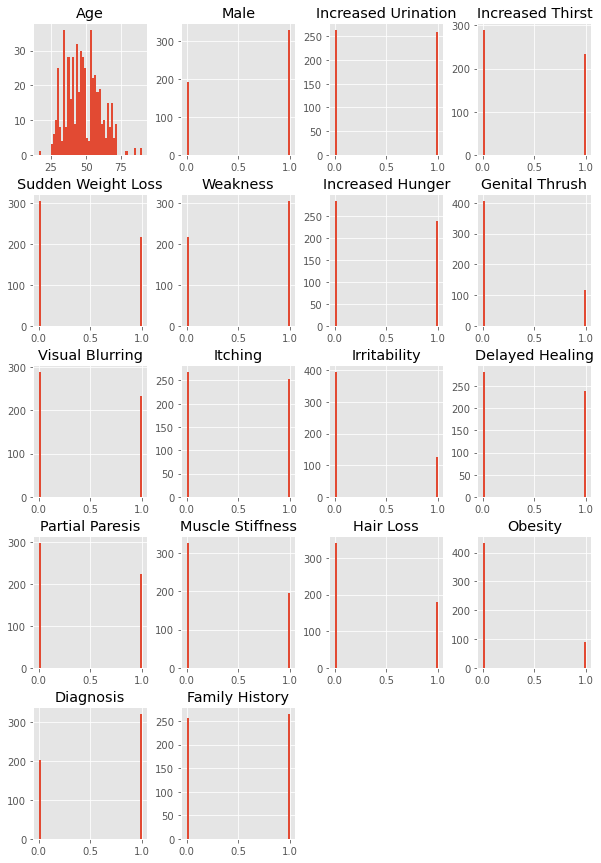

In [6]:
c_dataset.hist(bins=50, figsize=(10, 15))
plt.show()

Split dataset to features and label

In [7]:
feature_list = ['Age', 'Male',
                'Increased Urination', 'Increased Thirst',
                'Sudden Weight Loss', 'Weakness',
                'Increased Hunger', 'Genital Thrush',
                'Visual Blurring', 'Itching', 'Irritability',
                'Delayed Healing', 'Partial Paresis',
                'Muscle Stiffness', 'Hair Loss',
                'Obesity', 'Family History'
               ]
features = c_dataset[feature_list]
label = c_dataset[['Diagnosis']]

### Part 2
**Perform a test-train split of 20% test.**

In [8]:
X_train, x_test_orig, Y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=3, stratify=label)

### Part 3
**Provide a detailed visualization and exploration of the data.**

**a.** We show the distribution of the features is similar between test and train:

In [9]:
distribution_feat = X_train.drop(columns='Age').keys()
distribution_train = X_train.drop(columns='Age').mean()*100
distribution_test = x_test_orig.drop(columns='Age').mean()*100
distribution = {'Positive Feature':distribution_feat, 
                'Train %':distribution_train, 
                'Test %':distribution_test, 
                'Delta %':distribution_train-distribution_test}
distribution_table = pd.DataFrame(distribution)

avg_age = {'Train': X_train['Age'].mean(), 'Test': x_test_orig['Age'].mean()}
avg_age['Delta'] = avg_age['Train'] - avg_age['Test']
distribution_age = pd.DataFrame(avg_age, index=['Average Age'])

diagnosis = {'Train %': Y_train['Diagnosis'].mean()*100, 'Test %': y_test['Diagnosis'].mean()*100}
diagnosis['Delta %'] = diagnosis['Train %'] - diagnosis['Test %']
distribution_diagnosis = pd.DataFrame(diagnosis, index=['Diagnosis'])

display(distribution_diagnosis)
display(distribution_age)
display(distribution_table.style.hide_index())

,Train %,Test %,Delta %
Diagnosis,61.483254,60.952381,0.530873


,Train,Test,Delta
Average Age,47.760766,49.095238,-1.334473


Positive Feature,Train %,Test %,Delta %
Male,62.918660,63.809524,-0.890864
Increased Urination,50.000000,47.619048,2.380952
Increased Thirst,45.215311,41.904762,3.310549
Sudden Weight Loss,42.344498,38.095238,4.249260
Weakness,58.133971,60.000000,-1.866029
Increased Hunger,46.411483,41.904762,4.506721
Genital Thrush,21.770335,23.809524,-2.039189
Visual Blurring,43.779904,47.619048,-3.839143
Itching,47.846890,51.428571,-3.581681
Irritability,24.401914,23.809524,0.592390


**i. What issues could an imbalance of features between train and test cause?**

Imbalance of features between train and test sets could cause poor generalization; since the model would train with a set of different distribution from the general population.

**ii. How could you solve the issue?**

This issue could be solved by stratification, which splits the groups preserving the general distribution of the features for both groups.

**b.** We show the relationship between feature and label:

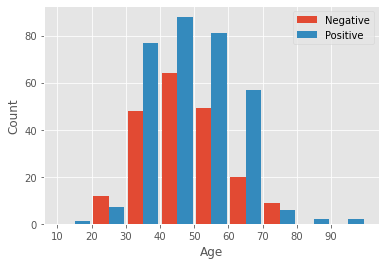

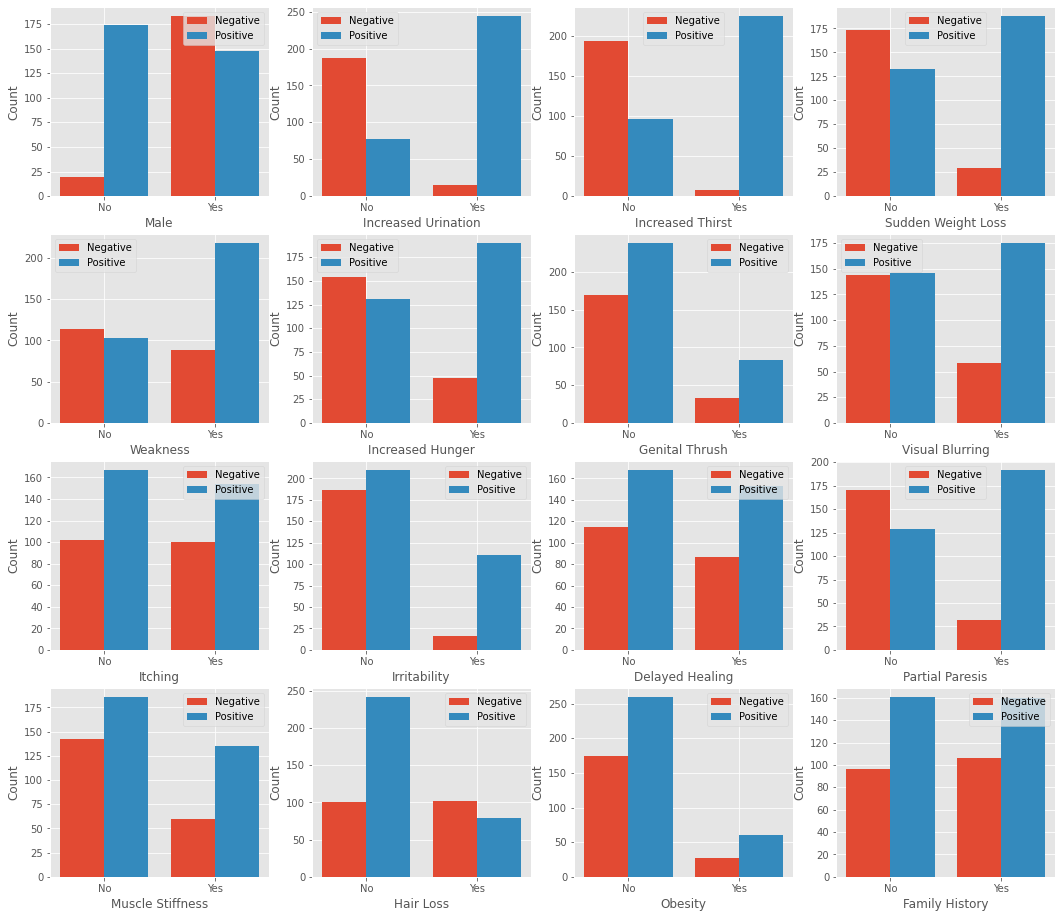

In [10]:
w = 0.4
w2 = 4.5

age_label0= np.zeros(9)
age_label1= np.zeros(9)

# Plot how many positives/negatives are in each 10 year range
for j in range(9):
    age_label0[j] = sum(features['Age'][i]>=10*(j+1) and features['Age'][i]<(10+10*(j+1)) and label.loc[i]==0 for i in features.index).item()
    age_label1[j] = sum(features['Age'][i]>=10*(j+1) and features['Age'][i]<(10+10*(j+1)) and label.loc[i]==1 for i in features.index).item()

plt.bar([15,25,35,45,55,65,75,85,95], age_label0, w2, label='Negative')
plt.bar([15,25,35,45,55,65,75,85,95] + np.repeat(w2,9), age_label1, w2, label='Positive')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks([10,20,30,40,50,60,70,80,90]+ np.repeat(w2/2,9),[10,20,30,40,50,60,70,80,90])
plt.legend()
plt.show()

fig = plt.figure(figsize = [18,16])
for feat in features.drop(columns='Age').columns:
    feat0_label0 = sum([features[feat][i]==0 and label.loc[i]==0 for i in features.index]).item()
    feat0_label1 = sum([features[feat][i]==0 and label.loc[i]==1 for i in features.index]).item()
    feat1_label0 = sum([features[feat][i]==1 and label.loc[i]==0 for i in features.index]).item()
    feat1_label1 = sum([features[feat][i]==1 and label.loc[i]==1 for i in features.index]).item()
    
    ax = fig.add_subplot(4,4,features.columns.get_loc(feat))
    ax.bar([0, 1], [feat0_label0, feat1_label0], w, label='Negative')
    ax.bar([w, 1+w], [feat0_label1, feat1_label1], w, label='Positive')
    ax.set_xlabel(feat)
    ax.set_ylabel('Count')
    ax.set_xticks([w/2,1+w/2])
    ax.set_xticklabels(['No','Yes'])
    ax.legend()


**c.** Additional plots - Heatmap:

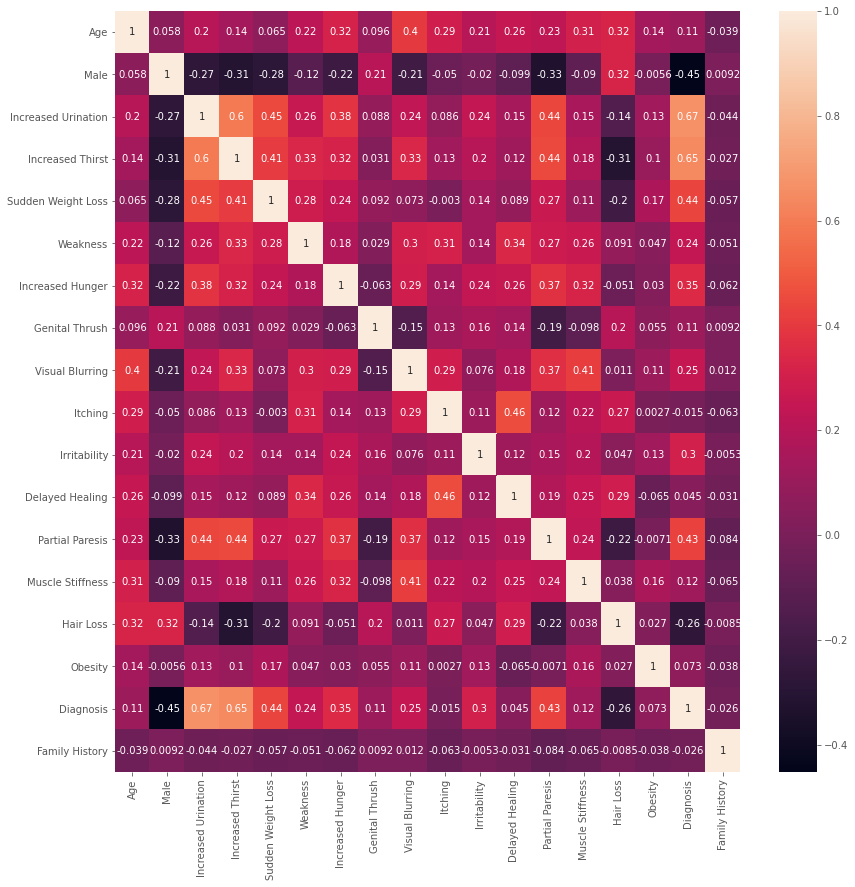

In [11]:
plt.figure(figsize = (14,14))
sns.heatmap(c_dataset.corr(), annot = True)
plt.show()

**d.** Insights:

From the graphs showing the diagnosis according to each feature, we conclude the following:

The following features are indicative of T1D:
* Increased urination
* Increased thirst
* Sudden weight loss
* Increased hunger
* Irritability
* Partial paresis

Other features indicative of T1D but with secondary importance:
* Visual blurring
* Weakness
* Muscle stiffness

We noticed that the number of female subjects that were diagnosed positively was unexpectedly high. We also noticed that most of the subjects with no hair loss were positive, unexpectedly. We concluded that this event might occurr since female subjects tend to have no hair loss. This assumption was confirmed by a positive correlation of 0.32 between being a male and having hair loss, shown in the heatmap.

From the heatmap we observe that the highest positive correlations between feature and diagnosis are increased urination and increased thirst. In addition, sudden weigth loss and partial paresis also show high positive correlation.
We also observe the highest negative correlation between diagnosis and being a male and hair loss, which we refered to above.

The features mentioned above with high positive correlation to having T1D are good predictors as expected since they are known symptomes of this disease.

### Part 4
**Encode all your data as one hot vectors.**

This process was done in *Part 1* except for 'Age' feature since there are many values available for this feature. We will only scale this feature:

In [12]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled['Age'] = scaler.fit_transform(X_train['Age'].values.reshape(-1, 1))
x_test = x_test_orig.copy()
x_test['Age'] = scaler.transform(x_test_orig['Age'].values.reshape(-1, 1))

In [13]:
X_train_scaled = X_train_scaled.values
x_test = x_test.values
Y_train = Y_train.values
y_test = y_test.values

### Part 5
**Choose, build and optimize Machine Learning Models.**

In [14]:
calc_TN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 0]
calc_FP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 1]
calc_FN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 0]
calc_TP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 1]

def print_stats(model, x_test, y_test):
    """
    print performance staistics and plot confusion matrix
    inputs: ML model, test set features and models
    """

    display(pd.DataFrame({'Performance statistics': return_stats(model, x_test, y_test)}).transpose())
    plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues)
    plt.grid(False)
    
def return_stats(model, x_test, y_test):
    y_pred_test = model.predict(x_test)
    y_pred_proba_test = model.predict_proba(x_test)
    loss = log_loss
    TN = calc_TN(y_test, y_pred_test)
    FP = calc_FP(y_test, y_pred_test)
    FN = calc_FN(y_test, y_pred_test)
    TP = calc_TP(y_test, y_pred_test)
    PPV = TP / (TP + FP)
    SE = TP / (TP + FN)
    SP = TN / (TN + FP)
    ACC = (TN + TP) / (TN + FN + TP + FP)
    F1 = 2 * PPV * SE / (PPV + SE)
    AUROC = roc_auc_score(y_test, y_pred_proba_test[:,1])
    
    if type(model)==LogisticRegression:
        loss = log_loss(y_test, y_pred_proba_test)
    else:
        hinge_y_test = np.array([2*i-1 for i in y_test])
        hinge_y_pred_test = np.array([2*i-1 for i in y_pred_test])
        loss = hinge_loss(hinge_y_test, hinge_y_pred_test)
    return {'Loss': loss, 'Sensitiviy': SE, 'Specificity': SP, 'Accuracy': ACC, 'F1': F1, 'AUROC': AUROC}

First, we will train a linear model with no regularization.

,AUROC,Accuracy,F1,Loss,Sensitiviy,Specificity
Performance statistics,0.969893,0.904762,0.919355,0.22375,0.890625,0.926829


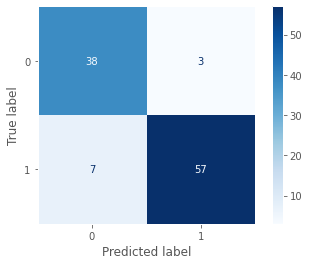

In [15]:
lr = LogisticRegression(random_state=5, max_iter=2000, solver='lbfgs')
lr.fit(X_train_scaled, Y_train.ravel())
print_stats(lr, x_test, y_test)

Create validation set and scale it

In [16]:
x_train_orig, x_val_orig, y_train, y_val= train_test_split(X_train, Y_train, test_size = 0.2, random_state = 4, stratify=Y_train)

In [17]:
scaler = StandardScaler()
x_train = x_train_orig.copy()
x_val = x_val_orig.copy()
x_train['Age'] = scaler.fit_transform(x_train_orig['Age'].values.reshape(-1, 1))
x_val['Age'] = scaler.transform(x_val_orig['Age'].values.reshape(-1, 1))

Next we find the best regularization parameters for our linear model.

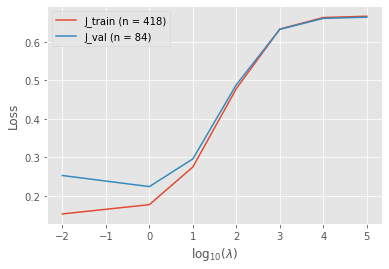

In [18]:
lmbda = np.array([0.01, 1, 10, 100, 1000, 1e04, 1e05])
J_train = np.zeros_like(lmbda)
J_val = np.zeros_like(lmbda)
for idx, lb in enumerate(lmbda):
    log_reg = LogisticRegression(random_state=5, max_iter=2000, solver='lbfgs', C=1/lb)
    log_reg.fit(x_train, y_train.ravel())
    J_train[idx] = log_loss(y_train, log_reg.predict_proba(x_train))
    J_val[idx] = log_loss(y_val, log_reg.predict_proba(x_val))

plt.plot(np.log10(lmbda), J_train)
plt.plot(np.log10(lmbda), J_val)
plt.xlabel('$\log_{10}(\lambda)$')
plt.ylabel('Loss')
plt.legend(['J_train (n = ' + str(X_train.shape[0]) + ')', 'J_val (n = ' + str(x_val.shape[0]) + ')'])
plt.show()

We observe that minimum validation loss is for $\lambda$ ~ 1

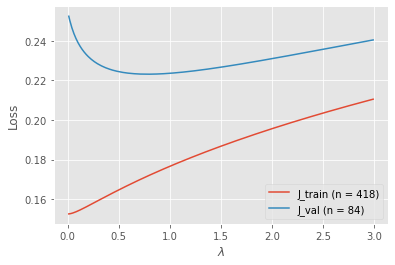

In [19]:
fine_lmbda = np.arange(0.01, 3, 0.01, dtype=np.float64)
J_train = np.zeros_like(fine_lmbda)
J_val = np.zeros_like(fine_lmbda)
for idx, lb in enumerate(fine_lmbda):
        C = 1/lb
        log_reg = LogisticRegression(random_state=5, max_iter=2000, solver='lbfgs', C=C)
        log_reg.fit(x_train, y_train.ravel())
        J_train[idx] = log_loss(y_train, log_reg.predict_proba(x_train))
        J_val[idx] = log_loss(y_val, log_reg.predict_proba(x_val))
        
plt.plot(fine_lmbda, J_train)
plt.plot(fine_lmbda, J_val)
plt.xlabel('$\lambda$')
plt.ylabel('Loss')
plt.legend(['J_train (n = ' + str(X_train.shape[0]) + ')', 'J_val (n = ' + str(x_val.shape[0]) + ')'])
plt.show()

In [20]:
C = 1/0.5 # best coefficient

We train a second linear model, this time with regularization.

,AUROC,Accuracy,F1,Loss,Sensitiviy,Specificity
Performance statistics,0.971037,0.904762,0.919355,0.213067,0.890625,0.926829


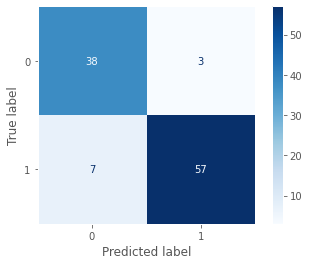

In [21]:
lr_regul = LogisticRegression(random_state=5, max_iter=2000, solver='lbfgs', C=C)
lr_regul.fit(X_train_scaled, Y_train.ravel())

print_stats(lr_regul, x_test, y_test)

Next we perform 5k cross fold validation with linear, rbf and poly kernels.

In [22]:
skf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
svc = SVC(probability=True)
C = np.array([1, 1.5, 2, 2.5, 3])
pipe = Pipeline(steps=[('svm', svc)])
svm = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['rbf', 'poly', 'linear'], 'svm__degree': [2, 3]},
                   scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf,
                   refit='roc_auc', verbose=1, return_train_score=True)
svm.fit(X_train_scaled, Y_train.ravel())
best_svm = svm.best_estimator_
svm.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.1s finished


{'svm__C': 2.5, 'svm__degree': 3, 'svm__kernel': 'poly'}

5k cross fold validation returned that the best of the models is a polynom of third degree with C = 2.5 .

Next we test the optimized SVM model.

,AUROC,Accuracy,F1,Loss,Sensitiviy,Specificity
Performance statistics,0.996951,0.952381,0.96,0.095238,0.9375,0.97561


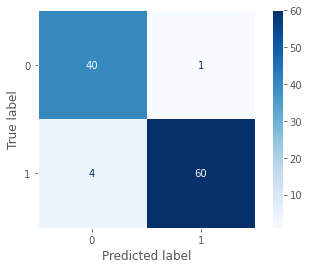

In [23]:
y_pred_test = best_svm.predict(x_test)
y_pred_proba_test = best_svm.predict_proba(x_test)
print_stats(best_svm, x_test, y_test)

The last non-linear model we train is a Random Forest Classifier.

,AUROC,Accuracy,F1,Loss,Sensitiviy,Specificity
Performance statistics,1.0,1.0,1.0,0.0,1.0,1.0


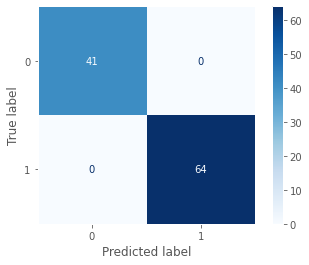

In [24]:
rfc = RandomForestClassifier(max_depth=10, random_state=0, criterion='gini')
rfc.fit(X_train_scaled, Y_train.ravel())
print_stats(rfc, x_test, y_test)

Finally we plot the ROC of the 4 trained models and show their evaluation metrics.

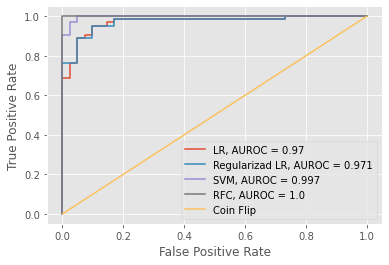

In [25]:
classifiers = [lr, lr_regul, best_svm, rfc]
roc_score = []
plt.figure()
ax = plt.gca()
for clf in classifiers:
    plot_roc_curve(clf, x_test, y_test, ax=ax)
    roc_score.append(np.round_(roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]), decimals=3))
ax.plot(np.linspace(0,1,x_test.shape[0]),np.linspace(0,1,x_test.shape[0]))
plt.legend(('LR, AUROC = '+str(roc_score[0]),'Regularizad LR, AUROC = '+str(roc_score[1]),
            'SVM, AUROC = '+str(roc_score[2]),'RFC, AUROC = '+str(roc_score[3]),'Coin Flip'))
plt.show()

In [26]:
model_evaluation_metrics = pd.DataFrame({'Linear': return_stats(lr, x_test, y_test),
                                         'Linear Regularized': return_stats(lr_regul, x_test, y_test), 
                                         'Polynomial SVM': return_stats(best_svm, x_test, y_test), 
                                         'Random Forest Classifier': return_stats(rfc, x_test, y_test)}).transpose()
display(model_evaluation_metrics)

,Loss,Sensitiviy,Specificity,Accuracy,F1,AUROC
Linear,0.223750,0.890625,0.926829,0.904762,0.919355,0.969893
Linear Regularized,0.213067,0.890625,0.926829,0.904762,0.919355,0.971037
Polynomial SVM,0.095238,0.937500,0.975610,0.952381,0.960000,0.996951
Random Forest Classifier,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In conclusion, we can observe both from the ROC and the evaluation metrices that non-linear models perform best on this dataset. In particular the random forest classifier model returns a perfect classification with 100% accuracy.

### Part 6
**Feature Selection**

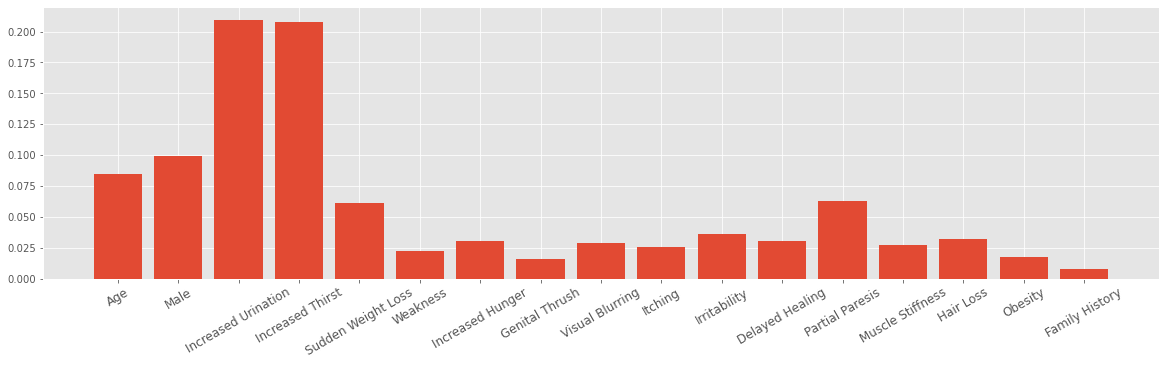

In [50]:
feature_importances = rfc.feature_importances_
plt.figure(figsize=(20,5))
plt.bar(feature_list, feature_importances)
plt.xticks(rotation=30, size=12)
plt.show()

From the RFC model we can see the 2 most important features are increades urination and increased thirst. This resurlt matches up our prediction from Part 3 that was based on both graphs showing the diagnosis according to each feature and the heatmap.

### Part 7
**Data Separability Visualization**

We will reduce the feature dimentionality to 2 using PCA

In [134]:
k_pca = KernelPCA(n_components=2, kernel='rbf')
X_train_pca = k_pca.fit_transform(X_train_scaled)
X_test_pca = k_pca.transform(x_test)

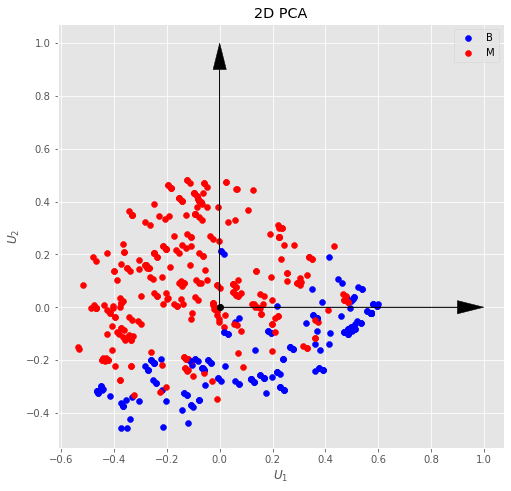

In [135]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, aspect='equal')
ax.scatter(X_train_pca[Y_train.ravel()==0, 0], X_train_pca[Y_train.ravel()==0, 1], color='b')
ax.scatter(X_train_pca[Y_train.ravel()==1, 0], X_train_pca[Y_train.ravel()==1, 1], color='r')
ax.scatter(X_test_pca[y_test.ravel()==0, 0], X_test_pca[y_test.ravel()==0, 1], color='b')
ax.scatter(X_test_pca[y_test.ravel()==1, 0], X_test_pca[y_test.ravel()==1, 1], color='r')
ax.legend(('B','M'))
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel('$U_1$')
ax.set_ylabel('$U_2$')
ax.set_title('2D PCA')
plt.show()

As we can see from the graph above, the reduced data is seperable, yet ideal results could not be obtained linearly and non linearly.

1


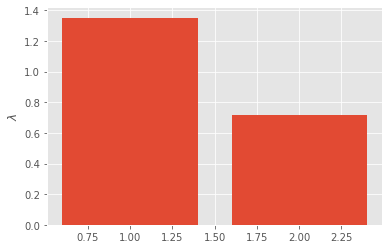

In [67]:
plt.bar(range(1,len(pca.explained_variance_)+1),pca.explained_variance_)
plt.ylabel('$\lambda$')
norm_lambda = np.cumsum(pca.explained_variance_)/pca.explained_variance_.sum()
print(np.argmax(norm_lambda>0.95))